In [1]:
import os
import numpy as np
import importlib
import random

import copy
import torch
from torch.utils.data import DataLoader

from utils.common import load_config,setup_seed
from data.dataset import ImageDataset
from models.models import Simple_CNN
from models.augment_network import SingleLayer

from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def get_feature(model, dataloader, config, device):
    model.eval()
    Loss = importlib.import_module('loss.'+config.loss)
    criterion = getattr(Loss, config.loss)(config)
    criterion = criterion.to(device)

    with torch.no_grad():
        features = []
        labels =[]
        probs=[]
        for i, batch in enumerate(dataloader):
            input_img_batch, label_batch, _ = batch 
            input_img = input_img_batch.reshape((-1, 3, input_img_batch.size(-2), input_img_batch.size(-1))).to(device)
            label = label_batch.reshape((-1)).to(device)
            prob, feature = model(input_img, data='dct')
            prob, _ = criterion(feature, prob)

            if i == 0:
                probs = prob
                gt_labels = label
                features = feature
            else:
                probs = torch.cat([probs, prob], dim=0)
                gt_labels = torch.cat([gt_labels, label])
                features=torch.cat(([features, feature]))

    features = features.cpu().numpy()
    probs = probs.cpu().numpy()
    labels = gt_labels.cpu().numpy()
        
    return features, labels, probs

In [3]:
def get_aug_feature(model, augnets, dataloader, device):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            input_img_batch, _, _ = batch 
            input_img = input_img_batch.reshape((-1, 3, input_img_batch.size(-2), input_img_batch.size(-1))).to(device)

            aug_imgs = []
            augnet_labels = []
            for idx, augnet in enumerate(augnets): 
                augnet.eval()
                aug_img = augnet(input_img)
                aug_imgs.append(aug_img)
                aug_label = idx * torch.ones(len(input_img))
                augnet_labels.append(aug_label)
                
            aug_imgs = torch.cat(aug_imgs)
            augnet_labels=torch.cat(augnet_labels)

            prob, feature = model(input_img, data='dct')
            aug_prob, aug_feature = model(aug_imgs, data='dct')
            
            if i == 0:
                all_augnet_labels = augnet_labels.cpu().numpy()
                features = feature.cpu().numpy()
                aug_features = aug_feature.cpu().numpy()
            else:
                all_augnet_labels = np.hstack([all_augnet_labels, augnet_labels.cpu().numpy()])
                features=np.vstack((features, feature.cpu().numpy()))
                aug_features = np.vstack((aug_features, aug_feature.cpu().numpy()))

    return features, aug_features, all_augnet_labels


In [4]:
def tsne_analyze(features, labels):
#     print(f">>> t-SNE fitting")
    embeddings = TSNE(n_jobs=4).fit_transform(features)
#     print(f"<<< fitting over")
    indexs = [i for i in range(len(embeddings))]
    random.shuffle(indexs)
    embeddings = np.array([embeddings[indexs[i]] for i in range(len(indexs))])
    labels = [labels[indexs[i]] for i in range(len(indexs))]
    vis_x = embeddings[:, 0]
    vis_y = embeddings[:, 1]
    
#     print(f">>> draw image begin")
    num_classes =  len(set(labels))
    plt.figure(figsize=(5,5))
    for i, lab in enumerate(list(range(num_classes))):
        if i < 20:
            color = plt.cm.tab20(i)
        else:
            color = plt.cm.tab20b(i-20)
        class_index = [j for j,v in enumerate(labels) if v == lab]
        if lab == 0:
            plt.scatter(vis_x[class_index], vis_y[class_index], color = color, alpha=1, marker='^', s=20)
        else:
            plt.scatter(vis_x[class_index], vis_y[class_index], color = color, alpha=1, marker='o')
    plt.xticks([])
    plt.yticks([])
#     print(f"<<< draw image end")

In [5]:
def plot_similarity_matrix(sim_matrix):
    plt.figure()
    plt.imshow(sim_matrix, cmap=plt.cm.Blues, vmin=0.5, vmax=1)
    plt.colorbar()
    plt.tight_layout() 
    plt.xticks([])
    plt.yticks([])

In [6]:
def progressive_visualization(data_loader, model_path):
    pretrain_model_paths = [os.path.join(model_path, 'model_epoch{}.pth'.format(epoch)) for epoch in [5,10,15,20]]
    aug_model_paths = [os.path.join(model_path,'augnet_{}.pth'.format(epoch)) for epoch in range(20)]
    augnets = []
    aug_network = SingleLayer(inc=32)
    for model_path in aug_model_paths:
        augnet = copy.deepcopy(aug_network) 
        augnet.load_state_dict(torch.load(model_path, map_location='cpu')['state_dict'])
        augnet = augnet.to(device)
        augnets.append(augnet)
    models = []
    for pretrain_model_path in pretrain_model_paths:
        model = Simple_CNN(class_num=15, out_feature_result=True)
        pretrained_dict = torch.load(pretrain_model_path, map_location='cpu')['state_dict']
        model.load_state_dict(pretrained_dict)
        model = model.to(device)
        models.append(model)

    for models, aug_num in zip(models, [5,10,15,20]):
        known_feature, aug_feature, aug_label = get_aug_feature(model, augnets[:aug_num], data_loader, device)
        known_label = np.ones(len(known_feature)) * 0
        aug_label = aug_label + 1
        tsne_analyze(np.vstack((known_feature, aug_feature)), np.hstack((known_label, aug_label)))
        plt.title('epoch {}'.format(aug_num))

    aug_feature_per_class = np.vstack([np.mean(aug_feature[aug_label==i+1],0) for i in range(aug_num)])
    sim_matrix = cosine_similarity(aug_feature_per_class, aug_feature_per_class)
    plot_similarity_matrix(sim_matrix)

In [7]:
device = 'cuda:6'
setup_seed(2)
config = load_config('configs.{}'.format('progressive'))

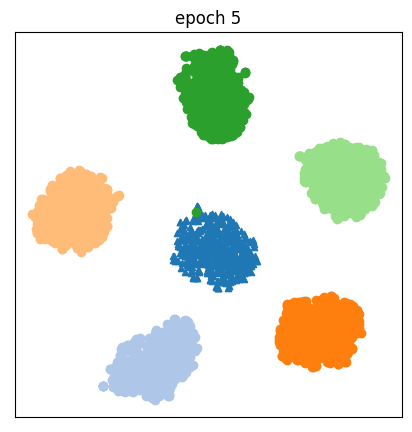

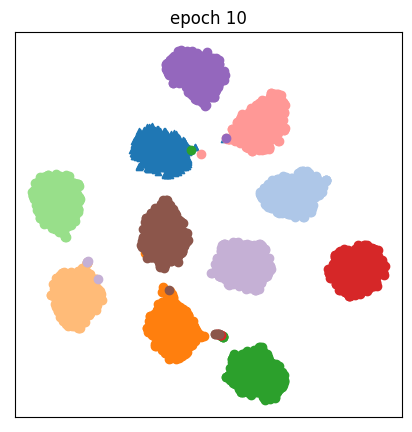

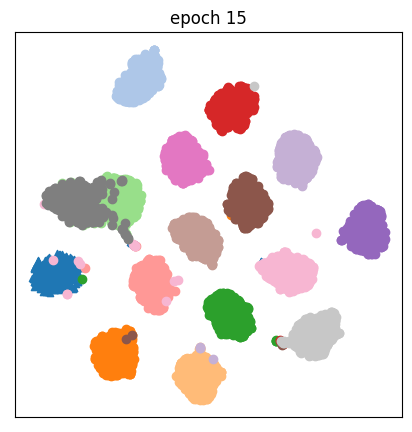

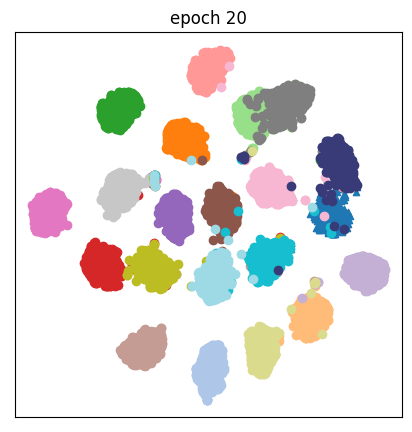

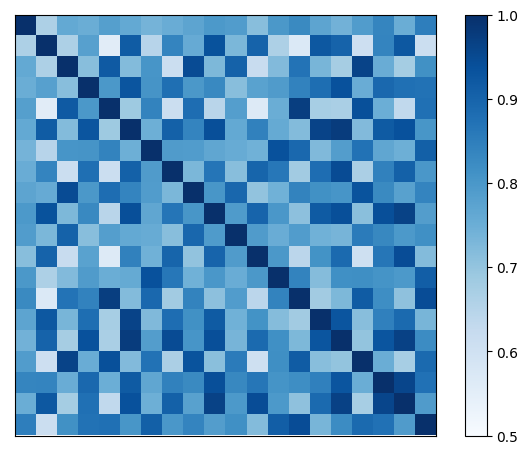

In [8]:
known_data_path = './dataset/OSMA_subset/fake/ProGAN/multiseed_celeba/celeba_align_png_cropped_seed_v0'
close_set = ImageDataset([(os.path.join(known_data_path, img_path), 0) for img_path in os.listdir(known_data_path)], config, balance=False, test_mode=True)
close_loader = DataLoader(
    dataset=close_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
model_path='./checkpoints/split1/models'
progressive_visualization(close_loader, model_path)

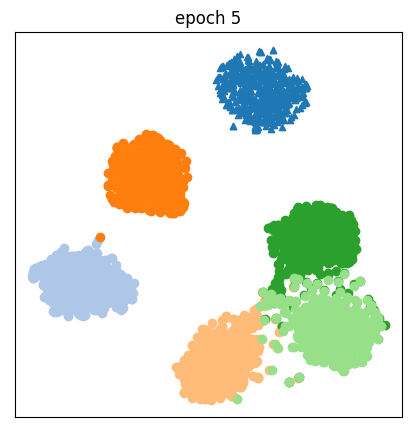

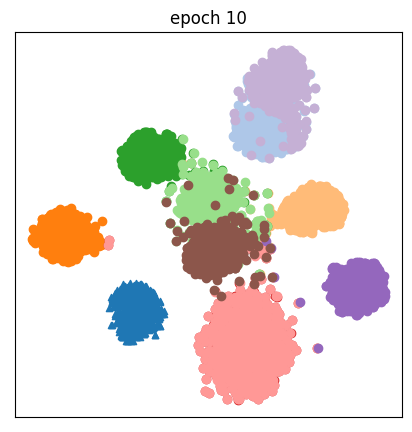

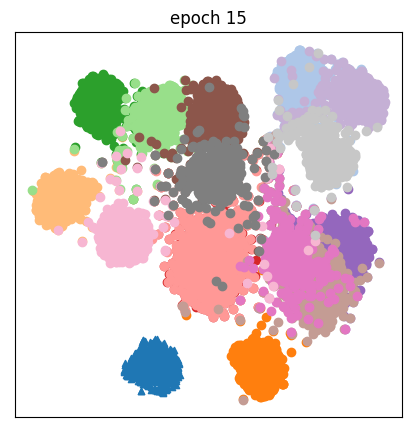

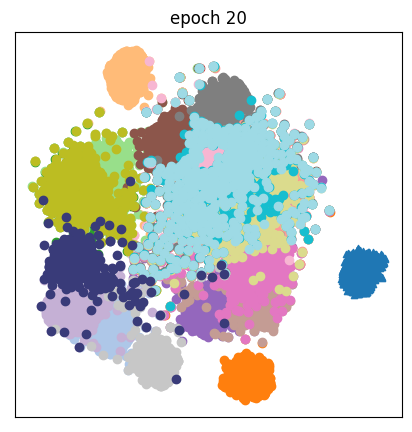

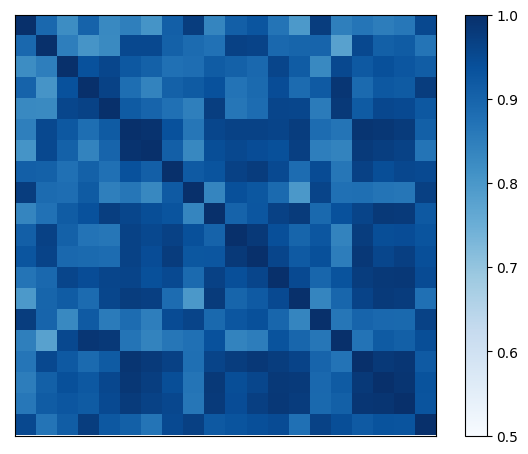

In [9]:
model_path='./checkpoints/split1/models_wo_div'
progressive_visualization(close_loader, model_path)

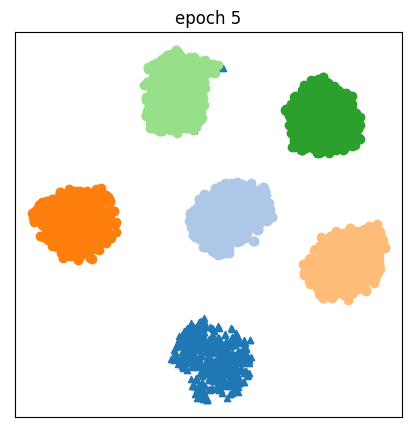

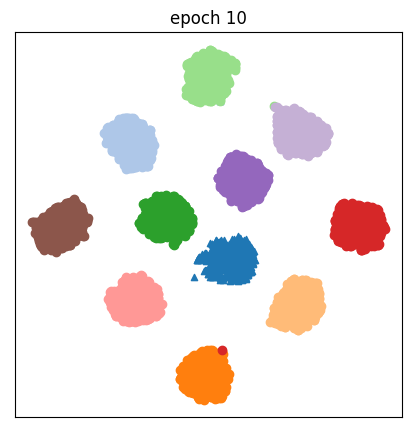

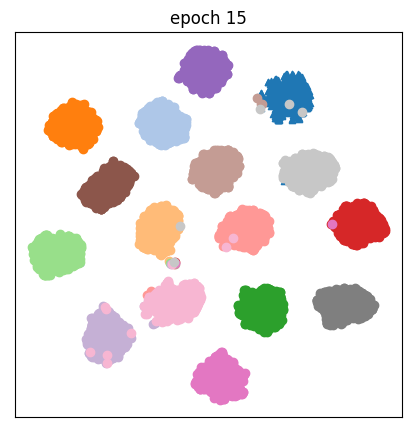

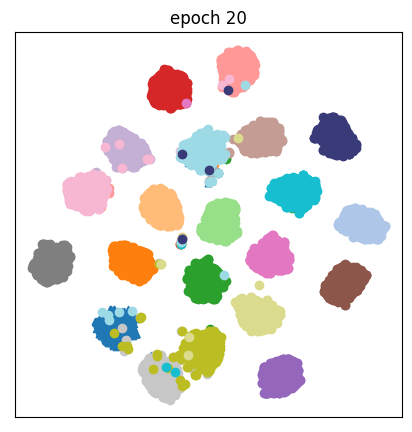

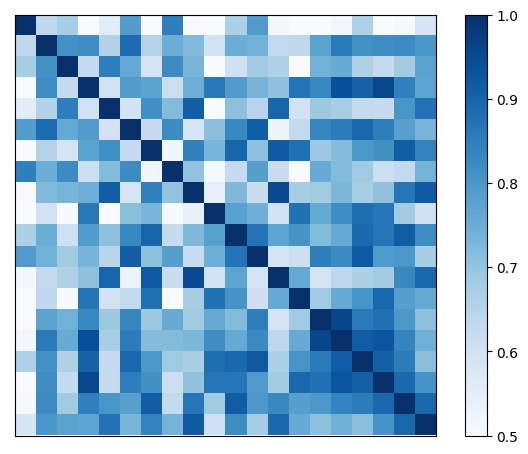

In [10]:
known_data_path = './dataset/OSMA_subset/fake/ProGAN/multiseed_celeba/celeba_align_png_cropped_seed_v1'
close_set = ImageDataset([(os.path.join(known_data_path, img_path), 0) for img_path in os.listdir(known_data_path)], config, balance=False, test_mode=True)
close_loader = DataLoader(
    dataset=close_set,
    num_workers=config.num_workers,
    batch_size=config.batch_size,
    pin_memory=True,
    shuffle=True,
    drop_last=False,
)
model_path='./checkpoints/split2/models'
progressive_visualization(close_loader, model_path)

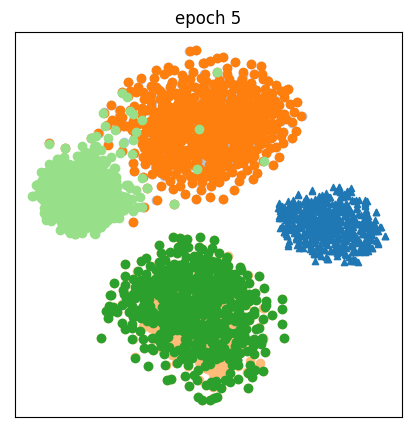

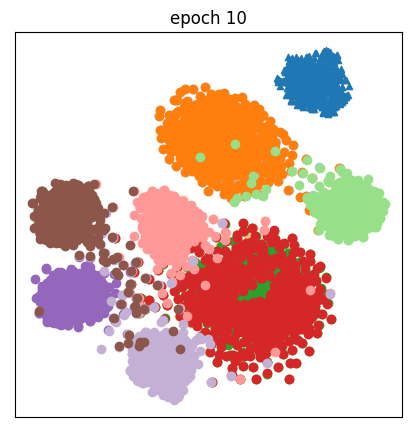

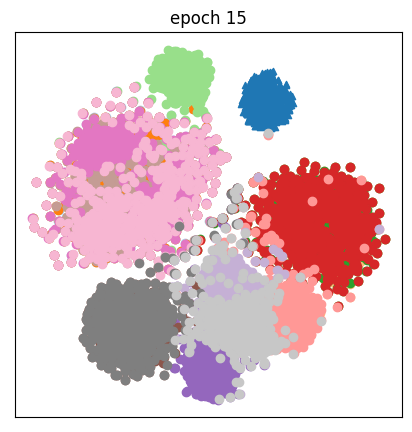

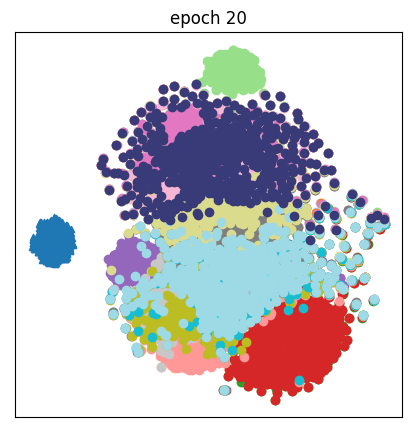

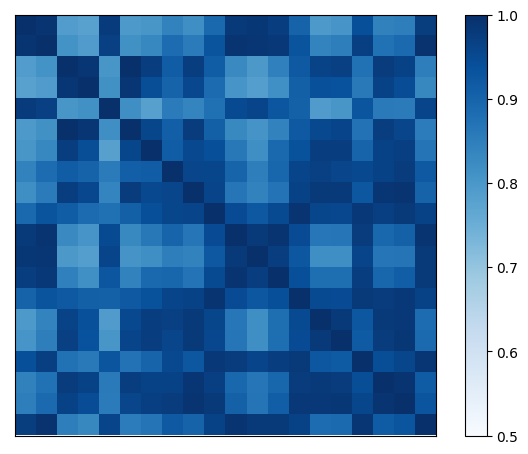

In [11]:
model_path='./checkpoints/split2/models_wo_div'
progressive_visualization(close_loader, model_path)